## Add Smart Cart Features 
<b> Objective: </b> 
<br>
Add compute recency/frequency/budget alignment, behavioral features, and product relationships.

In [1]:
# Feature Engineering
import pandas as pd
import numpy as np
from datetime import datetime

In [17]:
df = pd.read_csv('data/all_features_preference_features.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338619 entries, 0 to 1338618
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0.2         1338619 non-null  int64  
 1   Unnamed: 0.1         1338619 non-null  int64  
 2   Unnamed: 0           1338619 non-null  int64  
 3   transaction_id       1338619 non-null  object 
 4   user_id              1338619 non-null  object 
 5   product_code         1338619 non-null  int64  
 6   category             1338619 non-null  object 
 7   item_name            1338619 non-null  object 
 8   discount_percentage  1338619 non-null  float64
 9   transaction_date     1338619 non-null  object 
 10  transaction_price    1338619 non-null  float64
 11  age_group            1338619 non-null  object 
 12  gender               1338619 non-null  object 
 13  income_bracket       1338619 non-null  object 
 14  customer_type        1338619 non-null  object 
 15

In [18]:
len(df)

1338619

In [19]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Assuming your DataFrame is named 'df' and is already loaded.
# It should have columns: 'user_id', 'product_code', and a value column for interactions.
# If 'transaction_price' exists, use it. Otherwise, a simple 'interaction' column of 1s is fine.
# For example: df['interaction'] = 1.0

# Split data into training and testing for each user
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for user in df['user_id'].unique():
    user_data = df[df['user_id'] == user].copy()
    split_point = int(len(user_data) * 0.8) # 80% for training
    train_df = pd.concat([train_df, user_data.iloc[:split_point]])
    test_df = pd.concat([test_df, user_data.iloc[split_point:]])

# Create the user-item matrix from the training data
# This matrix will be the input for our recommendation model.
train_matrix = train_df.pivot_table(
    index='user_id',
    columns='product_code',
    values=df.columns[-1],  # Use the last column as the interaction value
    aggfunc='sum'
).fillna(0)

print(f"Total transactions: {len(df)}")
print(f"Training transactions: {len(train_df)}")
print(f"Testing transactions: {len(test_df)}")

Total transactions: 1338619
Training transactions: 1070877
Testing transactions: 267742


In [20]:
# Align columns to ensure the model sees all products from the original dataset
full_product_codes = df['product_code'].unique()
train_matrix = train_matrix.reindex(columns=full_product_codes, fill_value=0)
train_matrix_sparse = csr_matrix(train_matrix.values)

# Initialize and train the SVD model
svd = TruncatedSVD(n_components=50, random_state=42) # n_components is a tunable hyperparameter
svd.fit(train_matrix_sparse)

TruncatedSVD(n_components=50, random_state=42)

In [21]:
def precision_at_k(recommended_items, relevant_items, k):
    """Calculates Precision@K."""
    if not relevant_items:
        return 0.0
    
    recommended_set = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    
    hits = len(recommended_set.intersection(relevant_set))
    return hits / k if k > 0 else 0.0

k = 5 # Number of top recommendations to consider
user_precision_scores = {}
relevant_items_per_user = test_df.groupby('user_id')['product_code'].apply(list).to_dict()

for user_id in relevant_items_per_user:
    # Skip users not present in the training data
    if user_id not in train_matrix.index:
        continue

    # Get the user's vector from the training matrix
    user_row = train_matrix.loc[user_id].values.reshape(1, -1)
    
    # Make predictions for this user
    predicted_scores_user = svd.inverse_transform(svd.transform(user_row))
    predicted_scores_series = pd.Series(
        predicted_scores_user.flatten(),
        index=train_matrix.columns
    )
    
    # Exclude items the user has already seen to avoid recommending them again
    seen_items = list(train_df[train_df['user_id'] == user_id]['product_code'].unique())
    predicted_scores_filtered = predicted_scores_series[~predicted_scores_series.index.isin(seen_items)]
    
    # Get the top K recommended items
    recommended_items = predicted_scores_filtered.sort_values(ascending=False).head(k).index.tolist()
    
    # Get the actual items the user interacted with in the test set (the ground truth)
    relevant_items = relevant_items_per_user[user_id]
    
    # Calculate and store the precision score for this user
    score = precision_at_k(recommended_items, relevant_items, k)
    user_precision_scores[user_id] = score
    print(f"Precision@{k} for User '{user_id}': {score:.2f} ({score*100:.0f}%)")

# Calculate and print the overall average precision
if user_precision_scores:
    overall_precision = np.mean(list(user_precision_scores.values()))
    print(f"\nOverall Mean Precision@{k}: {overall_precision:.2f} ({overall_precision*100:.0f}%)")
else:
    print("No users found in the test set to evaluate.")

Precision@5 for User 'user_1': 0.00 (0%)
Precision@5 for User 'user_10': 0.00 (0%)
Precision@5 for User 'user_11': 0.00 (0%)
Precision@5 for User 'user_12': 0.00 (0%)
Precision@5 for User 'user_13': 0.00 (0%)
Precision@5 for User 'user_14': 0.00 (0%)
Precision@5 for User 'user_15': 0.00 (0%)
Precision@5 for User 'user_16': 0.00 (0%)
Precision@5 for User 'user_17': 0.00 (0%)
Precision@5 for User 'user_18': 0.00 (0%)
Precision@5 for User 'user_19': 0.00 (0%)
Precision@5 for User 'user_2': 0.00 (0%)
Precision@5 for User 'user_20': 0.00 (0%)
Precision@5 for User 'user_21': 0.00 (0%)
Precision@5 for User 'user_22': 0.00 (0%)
Precision@5 for User 'user_23': 0.00 (0%)
Precision@5 for User 'user_24': 0.00 (0%)
Precision@5 for User 'user_25': 0.00 (0%)
Precision@5 for User 'user_26': 0.40 (40%)
Precision@5 for User 'user_27': 0.00 (0%)
Precision@5 for User 'user_28': 0.00 (0%)
Precision@5 for User 'user_29': 0.00 (0%)
Precision@5 for User 'user_3': 0.00 (0%)
Precision@5 for User 'user_30': 0.00

c:\Users\rayed\anaconda3\envs\dolfin\Lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


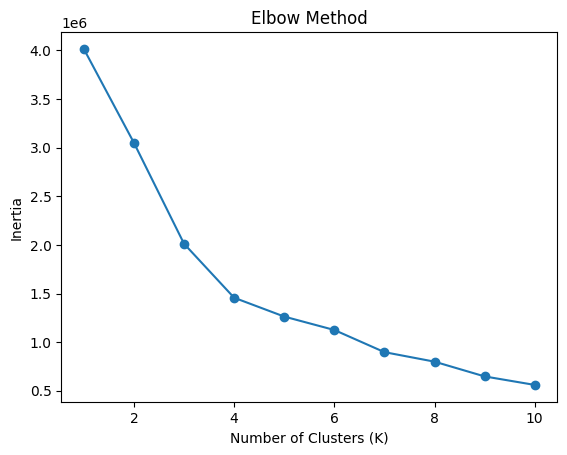

Using the elbow method plot, choose a K where the decrease in inertia slows down.


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains the new columns.
# --- 1. Prepare the Data ---
# Select the RFM-like features
features = ['recency_days', 'freq_30d', 'budget_alignment']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Determine the Optimal Number of Clusters (K) ---
# Use the Elbow Method to find the best K
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()
print("Using the elbow method plot, choose a K where the decrease in inertia slows down.")


In [23]:
# In a real scenario, you would inspect the plot and choose an appropriate K.
# Let's assume we choose K=4 for this example.
optimal_k = 4

# --- 3. Train the K-Means Model ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X_scaled)

print("\nK-Means Model Trained. Users are now assigned to a cluster.")
print(df.head())

# --- 4. Analyze Cluster Profiles for Recommendations ---
# Here you would link the clusters to product data
# For example: df_with_products.groupby('cluster')['product_code'].value_counts()
# This allows you to find the most popular items within each cluster.

# --- 5. Evaluation ---
# For clustering, the primary evaluation is **internal validation**.
# It measures how well-defined the clusters are, not predictive accuracy.
silhouette_avg = silhouette_score(X_scaled, df['cluster'])
print(f"\nSilhouette Score: {silhouette_avg:.2f}")

# A silhouette score close to +1 indicates well-separated clusters.
# A score near 0 indicates overlapping clusters.
# A score near -1 indicates bad clustering.


K-Means Model Trained. Users are now assigned to a cluster.
   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 transaction_id user_id  \
0             0             0           0     452a413df6  user_1   
1             1             1           1     452a413df6  user_1   
2             2             2           2     452a413df6  user_1   
3             3             3           3     dd22f95cce  user_1   
4             4             4           4     dd22f95cce  user_1   

   product_code              category  \
0       5355182  MENS DEOS & GROOMING   
1       9050664                SNACKS   
2       5055940           INFANT FOOD   
3       3994635          BAKING MIXES   
4       4842440         DENTAL HEALTH   

                                  item_name  discount_percentage  \
0  Deo Roll On Men Intense Protection Fresh             0.500000   
1           Original Multipack Potato Chips             0.416667   
2                              Puffcorn BBQ             0.157895   
3          

KeyboardInterrupt: 